In [1]:
import sys
import torch 
import torch as th 
import torch.nn as nn
import os
from os.path import join
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import einops
from torch.utils.data import Dataset, DataLoader, TensorDataset
sys.path.append('/n/home12/binxuwang/Github/DiffusionReasoning')
from stats_plot_utils import saveallforms, add_rectangles

In [2]:
def sweep_classifier_result(repr_dir, t_list=[0, 1, 10, 25, 50, 100, 250, 500, 1000], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=False):
    syn_df_all = []
    # t_scalar = 0.1
    for t_scalar in t_list:
        for epoch in epoch_list:
            t_str = str(t_scalar).replace(".", "_")
            for dimred_str in dimred_strs:
                ckpt_str = "RNDINIT" if epoch == -1 else \
                           f"{epoch:07d}{'EMA' if use_ema else ''}"
                try:
                    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl"), "rb"))
                except FileNotFoundError:
                    print(f"File not found: {repr_dir}/results_col_t{t_str}_{dimred_str}_ckpt{ckpt_str}.pkl")
                    continue
                test_acc_synopsis = {key: results_col[key].test_acc for key in results_col.keys()}
                train_acc_synopsis = {key: results_col[key].train_record.accuracy.max() for key in results_col.keys()}
                syn_df = pd.DataFrame([test_acc_synopsis, train_acc_synopsis]).T
                syn_df.columns = ["Test Accuracy", "Train Accuracy"]
                syn_df["t"] = t_scalar
                syn_df["epoch"] = epoch
                syn_df["dimred"] = dimred_str
                # drop index as layer name
                syn_df = syn_df.reset_index()
                syn_df = syn_df.rename(columns={"index": "Layer"})
                syn_df_all.append(syn_df)
        
    syn_df_all = pd.concat(syn_df_all, axis=0)
    syn_df_all = syn_df_all.reset_index(drop=True)
    return syn_df_all

In [ ]:
!ls {exproot}/090*/repr_classifier

model_PCA_col_t0_0_avgtoken_ckpt0020000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0020000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0100000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0100000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0200000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0200000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0500000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0500000.pkl
model_PCA_col_t0_0_avgtoken_ckpt0700000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt0700000.pkl
model_PCA_col_t0_0_avgtoken_ckpt1000000EMA.pkl
model_PCA_col_t0_0_avgtoken_ckpt1000000.pkl
model_PCA_col_t0_0_avgtoken_ckptRNDINIT.pkl
model_PCA_col_t0_0_pca1024_ckpt1000000.pkl
model_PCA_col_t0_0_pca128_ckpt1000000.pkl
model_PCA_col_t0_0_pca384_ckpt0020000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0020000.pkl
model_PCA_col_t0_0_pca384_ckpt0100000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0100000.pkl
model_PCA_col_t0_0_pca384_ckpt0200000EMA.pkl
model_PCA_col_t0_0_pca384_ckpt0200000.pkl
model_PCA_col_t0_0_pca384_ckpt0500000EMA.pkl
model_PCA_col_t0_0_

In [3]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = r"090-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20240711-0204"

In [14]:
!ls {exproot} | grep "^10[3-8]"

103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel3_20241113-0056
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel5_20241113-0057
108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057


In [19]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expname = "106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
repr_dir = join(expdir, "repr_classifier")
syn_df_DiT = sweep_classifier_result(repr_dir, t_list=[0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0], 
                            epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                            dimred_strs=["pca384", "avgtoken"], use_ema=False)

figexpdir = join(figroot, expname)
os.makedirs(figexpdir, exist_ok=True)
expname_short = expname.split("/")[-1].split("_2024")[0]
syn_df_DiT.to_csv(join(repr_dir, "repr_classifier_synopsis.csv"), index=False)
syn_df_DiT.to_csv(join(figexpdir, "repr_classifier_synopsis.csv"), index=False)

File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/repr_classifier/results_col_t1_0_pca384_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/repr_classifier/results_col_t1_0_avgtoken_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/repr_classifier/results_col_t1_0_pca384_ckpt0020000.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052/repr_classifier/results_col_t1_0_avgtoken_ckpt0020000.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Pr

In [26]:
print(syn_df_DiT.nlargest(5, "Test Accuracy"))  # [["Layer", "Test Accuracy", "Train Accuracy", "t", "epoch", "dimred"]]

,Layer,Test Accuracy,Train Accuracy,t,epoch,dimred
199,blocks.11,0.990800,0.999992,25.0,700000,avgtoken
189,blocks.11,0.989250,0.999967,25.0,500000,avgtoken
259,blocks.11,0.987925,0.999450,50.0,500000,avgtoken
269,blocks.11,0.986625,0.999358,50.0,700000,avgtoken
209,blocks.11,0.986400,0.999975,25.0,1000000,avgtoken


In [29]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
syndir = join(figroot, "synopsis")
os.makedirs(syndir, exist_ok=True)

In [5]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
syndir = join(figroot, "synopsis")

In [4]:
figroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expnames = [
    "103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052",
    "104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052",
    "104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052", 
    "105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052",
    "106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052",
    "106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052",
    "107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056",
    "107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056",
    "107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056",
    "107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel3_20241113-0056",
    "108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel5_20241113-0057",
    "108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057"
]
syn_df_DiT_col = {}
for expname in expnames:
    expdir = join(exproot, expname)
    ckptdir = join(expdir, "checkpoints")
    repr_dir = join(expdir, "repr_classifier")
    syn_df_DiT = sweep_classifier_result(repr_dir, t_list=[0.0, 1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0], 
                                epoch_list=[-1, 20000, 100000, 200000, 500000, 700000, 1000000 ],
                                dimred_strs=["pca384", "avgtoken"], use_ema=False)
    figexpdir = join(figroot, expname)
    os.makedirs(figexpdir, exist_ok=True)
    expname_short = expname.split("/")[-1].split("_2024")[0]
    syn_df_DiT.to_csv(join(repr_dir, "repr_classifier_synopsis.csv"), index=False)
    syn_df_DiT.to_csv(join(figexpdir, "repr_classifier_synopsis.csv"), index=False)
    print(expname)
    print(syn_df_DiT.nlargest(5, "Test Accuracy"))
    # add a column for expname
    syn_df_DiT["expname"] = expname
    syn_df_DiT_col[expname] = syn_df_DiT 

syn_df_DiT_cat = pd.concat(syn_df_DiT_col.values(), axis=0)
syn_df_DiT_cat
syn_df_DiT_cat.to_csv(join(syndir, "repr_classifier_synopsis_increasing_heldout.csv"), index=False)

File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052/repr_classifier/results_col_t1_0_pca384_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052/repr_classifier/results_col_t1_0_avgtoken_ckptRNDINIT.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052/repr_classifier/results_col_t1_0_pca384_ckpt0020000.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results/103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052/repr_classifier/results_col_t1_0_avgtoken_ckpt0020000.pkl
File not found: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwa

NameError: name 'syndir' is not defined

In [6]:
syn_df_DiT_cat.to_csv(join(syndir, "repr_classifier_synopsis_increasing_heldout.csv"), index=False)

### Synopsis across the 12 runs

In [7]:
syn_df_DiT_cat = pd.read_csv(join(syndir, "repr_classifier_synopsis_increasing_heldout.csv"))

In [8]:
# find the 5 largest Test Accuracy for each expname
syn_df_DiT_cat.groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


/tmp/ipykernel_3075798/4236398127.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  syn_df_DiT_cat.groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


,,Layer,Test Accuracy,Train Accuracy,t,epoch,dimred,expname
expname,,,,,,,,
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052,189,blocks.11,0.976150,0.993642,25.0,500000,avgtoken,103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052,1149,blocks.11,0.991150,0.999708,25.0,1000000,avgtoken,104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052,679,blocks.11,0.997125,1.000000,25.0,1000000,avgtoken,104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052,1619,blocks.11,0.996575,1.000000,25.0,1000000,avgtoken,105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052,2539,blocks.11,0.985675,0.998225,25.0,500000,avgtoken,106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052,2079,blocks.11,0.990800,0.999992,25.0,700000,avgtoken,106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056,3019,blocks.11,0.978750,0.987108,25.0,700000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056,3559,blocks.11,0.993700,0.999950,50.0,700000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056,3969,blocks.11,0.996350,1.000000,25.0,1000000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...


In [9]:
# find the 5 largest Test Accuracy for each expname, limit to 1000000 epoch
syn_df_DiT_cat.query("epoch == 1000000").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))

/tmp/ipykernel_3075798/901570136.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  syn_df_DiT_cat.query("epoch == 1000000").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


,,Layer,Test Accuracy,Train Accuracy,t,epoch,dimred,expname
expname,,,,,,,,
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052,138,blocks.8,0.935900,0.970458,10.0,1000000,avgtoken,103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052,1149,blocks.11,0.991150,0.999708,25.0,1000000,avgtoken,104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052,679,blocks.11,0.997125,1.000000,25.0,1000000,avgtoken,104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052,1619,blocks.11,0.996575,1.000000,25.0,1000000,avgtoken,105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052,2559,blocks.11,0.975700,0.995492,25.0,1000000,avgtoken,106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052,2089,blocks.11,0.986400,0.999975,25.0,1000000,avgtoken,106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056,3029,blocks.11,0.977850,0.987575,25.0,1000000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056,3498,blocks.8,0.993225,0.999950,25.0,1000000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056,3969,blocks.11,0.996350,1.000000,25.0,1000000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...


In [47]:
# find the 5 largest Test Accuracy for each expname, limit to 25.0 t and blocks.11 layer
syn_df_DiT_cat.query("dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))

/tmp/ipykernel_2712321/2726978435.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  syn_df_DiT_cat.query("dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


,,Layer,Test Accuracy,Train Accuracy,t,epoch,dimred,expname
expname,,,,,,,,
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052,189,blocks.11,0.976150,0.993642,25.0,500000,avgtoken,103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052,209,blocks.11,0.991150,0.999708,25.0,1000000,avgtoken,104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052,209,blocks.11,0.997125,1.000000,25.0,1000000,avgtoken,104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052,209,blocks.11,0.996575,1.000000,25.0,1000000,avgtoken,105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052,189,blocks.11,0.985675,0.998225,25.0,500000,avgtoken,106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052,199,blocks.11,0.990800,0.999992,25.0,700000,avgtoken,106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056,199,blocks.11,0.978750,0.987108,25.0,700000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056,199,blocks.11,0.991650,0.999650,25.0,700000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056,209,blocks.11,0.996350,1.000000,25.0,1000000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...


In [37]:
# find the 5 largest Test Accuracy for each expname, limit to 1000000 epoch
syn_df_DiT_cat.query("epoch == 1000000 and dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))

/tmp/ipykernel_2712321/3698773243.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  syn_df_DiT_cat.query("epoch == 1000000 and dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'").groupby("expname").apply(lambda x: x.nlargest(1, "Test Accuracy"))


,,Layer,Test Accuracy,Train Accuracy,t,epoch,dimred,expname
expname,,,,,,,,
103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052,209,blocks.11,0.880300,0.922150,25.0,1000000,avgtoken,103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052,209,blocks.11,0.991150,0.999708,25.0,1000000,avgtoken,104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052,209,blocks.11,0.997125,1.000000,25.0,1000000,avgtoken,104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052,209,blocks.11,0.996575,1.000000,25.0,1000000,avgtoken,105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052,209,blocks.11,0.975700,0.995492,25.0,1000000,avgtoken,106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052,209,blocks.11,0.986400,0.999975,25.0,1000000,avgtoken,106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056,209,blocks.11,0.977850,0.987575,25.0,1000000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056,209,blocks.11,0.990650,0.999483,25.0,1000000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056,209,blocks.11,0.996350,1.000000,25.0,1000000,avgtoken,107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16...


In [ ]:
import json
from pprint import pprint

In [42]:
# try to load the args.json for each expname
heldout_profiles = {}
for expname in expnames:
    expdir = join(exproot, expname)
    args_path = join(expdir, "args.json")
    if os.path.exists(args_path):
        args = json.load(open(args_path, "r"))
        heldout_ids = args["heldout_ids"]
        heldout_profiles[expname] = heldout_ids
    else:
        print(f"Args file not found for {expname}")

{'103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052': [1, 16, 20, 34, 37, 8, 12, 24, 36, 39, 5, 17, 21, 33, 38, 3, 10, 29, 31, 37, 0, 14, 27, 35, 38, 4, 19, 26, 30, 39], '104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052': [1, 16, 20, 34, 37, 8, 12, 24, 36, 39], '104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052': [1, 16, 20, 34, 37, 8, 12, 24, 36, 39, 5, 17, 21, 33, 38], '105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052': [1, 16, 20, 34, 37], '106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052': [1, 16, 20, 34, 37, 8, 12, 24, 36, 39, 5, 17, 21, 33, 38, 3, 10, 29, 31, 37], '106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052': [1, 16, 20, 34, 37, 8, 12, 24, 36, 39, 5, 17, 21, 33, 38, 3, 10, 29, 31, 37, 0, 14, 27, 35, 38], '107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], '107-RAVEN10_abstr

In [46]:
for expname, heldout_ids in heldout_profiles.items():
    print(expname, '\t heldout #', len(set(heldout_ids)), set(heldout_ids))

103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052 	 heldout # 27 {0, 1, 3, 4, 5, 8, 10, 12, 14, 16, 17, 19, 20, 21, 24, 26, 27, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39}
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052 	 heldout # 10 {1, 34, 36, 37, 39, 8, 12, 16, 20, 24}
104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052 	 heldout # 15 {1, 34, 33, 36, 37, 5, 39, 8, 38, 12, 16, 17, 20, 21, 24}
105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052 	 heldout # 5 {1, 34, 37, 16, 20}
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052 	 heldout # 19 {1, 3, 5, 8, 10, 12, 16, 17, 20, 21, 24, 29, 31, 33, 34, 36, 37, 38, 39}
106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052 	 heldout # 23 {0, 1, 3, 5, 8, 10, 12, 14, 16, 17, 20, 21, 24, 27, 29, 31, 33, 34, 35, 36, 37, 38, 39}
107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056 	 heldout # 1

### Summary or Synopsis across runs

### Individual rune inspection

In [32]:
import json
from sklearn.metrics import confusion_matrix
from stats_plot_utils import add_rectangles, plot_rule_heatmap

In [27]:
train_attrs = np.load("/n/home12/binxuwang/Github/DiffusionReasoning/attr_all.npy")
train_attrs = th.from_numpy(train_attrs).to(int)
train_row_img = einops.rearrange(train_attrs, 'c s pnl (H W) att -> c s att H (pnl W)', H=3, W=3, att=3, pnl=3)
train_sample_img = einops.rearrange(train_row_img, 'c (S R) att H W -> c S att (R H) W', R=3,att=3, H=3, W=9)
labels_tsr = torch.arange(len(train_sample_img)).to(int).view(-1,1).repeat(1, train_sample_img.shape[1])

X_train = train_sample_img[:, :3000]
y_train = labels_tsr[:, :3000]
X_test = train_sample_img[:, 3000:]
y_test = labels_tsr[:, 3000:]
X_train = X_train.reshape(-1, 3, 9, 9)
y_train = y_train.reshape(-1)
X_test = X_test.reshape(-1, 3, 9, 9)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([120000, 3, 9, 9]) torch.Size([120000]) torch.Size([40000, 3, 9, 9]) torch.Size([40000])


In [61]:
figexpdir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe/108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057'

In [64]:
syndir

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Figures/DiffusionReasoning/Figure_repr_linear_probe/synopsis'

103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.8803         0.92215  25.0  1000000  avgtoken


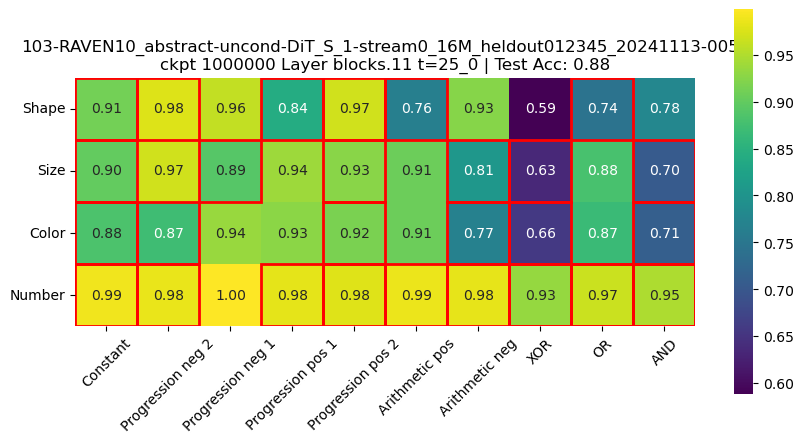

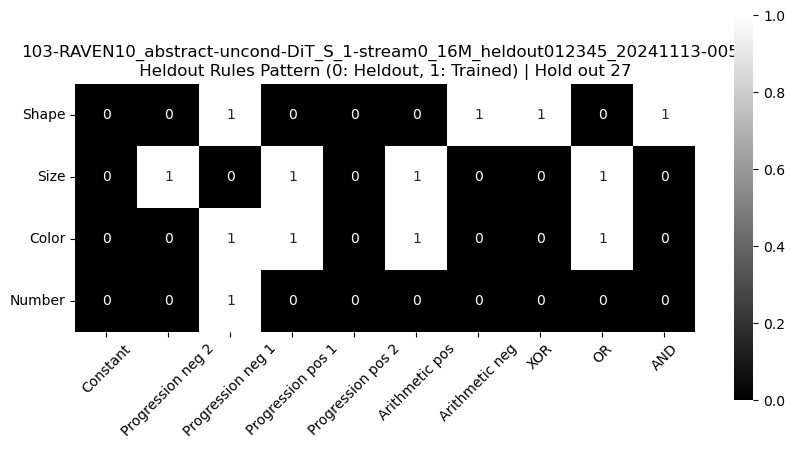

103-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012345_20241113-0052 t-stat: -0.42, p-val: 6.74e-01


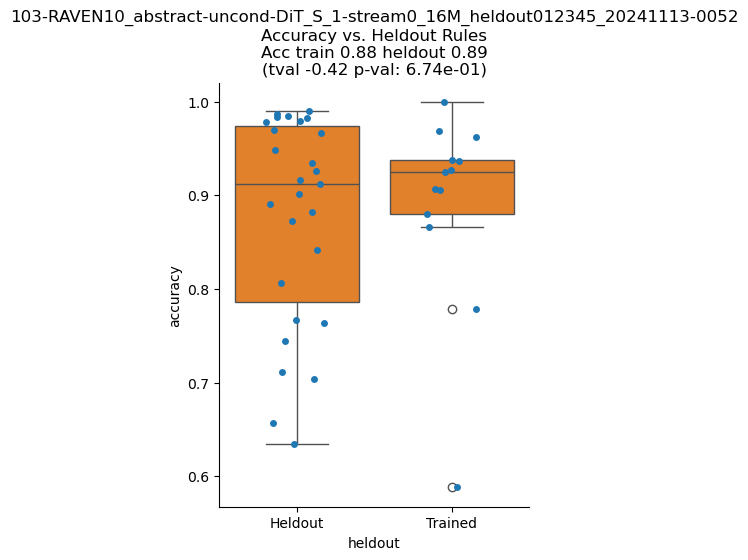

104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11       0.997125             1.0  25.0  1000000  avgtoken


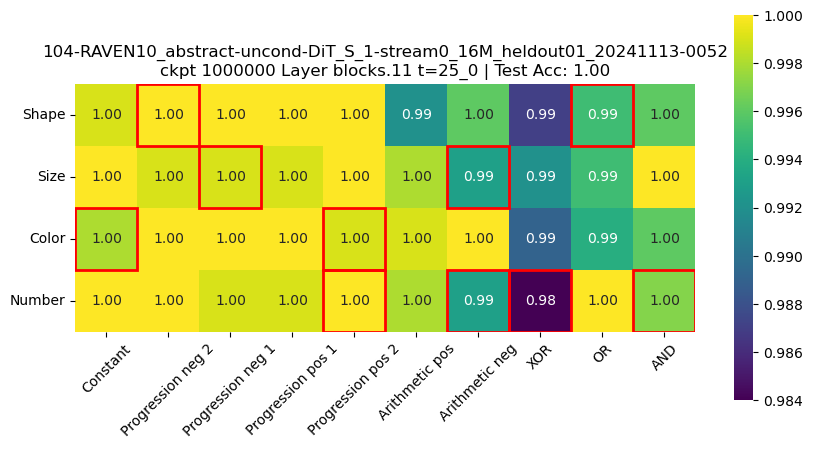

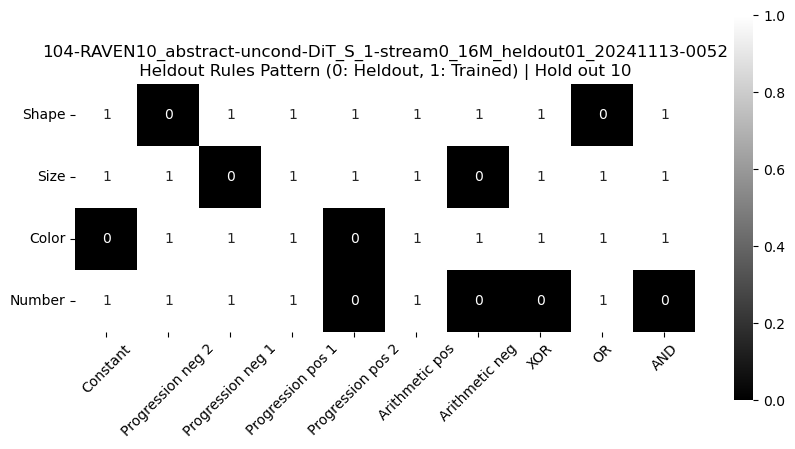

104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01_20241113-0052 t-stat: -1.24, p-val: 2.24e-01


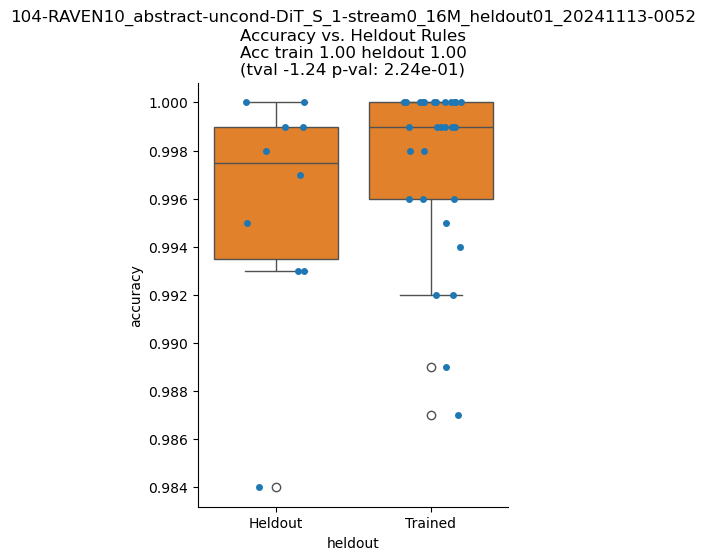

104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11        0.99115        0.999708  25.0  1000000  avgtoken


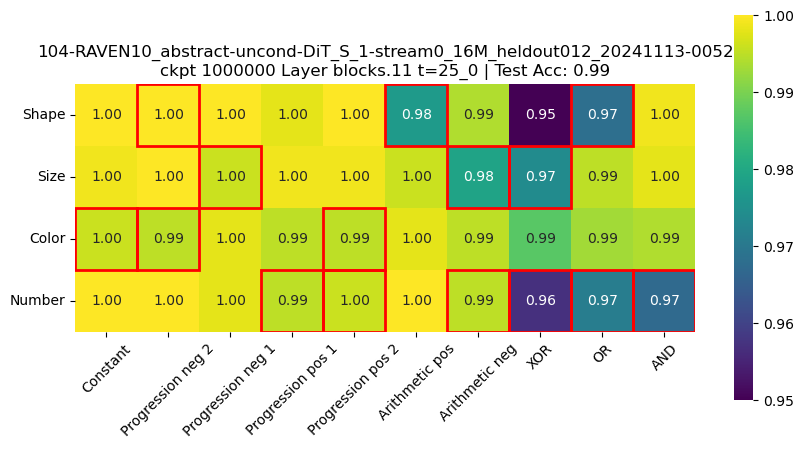

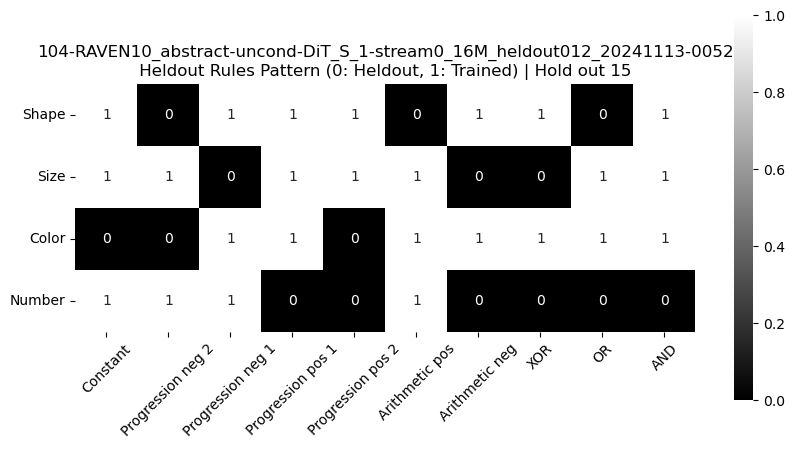

104-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout012_20241113-0052 t-stat: -2.98, p-val: 5.05e-03


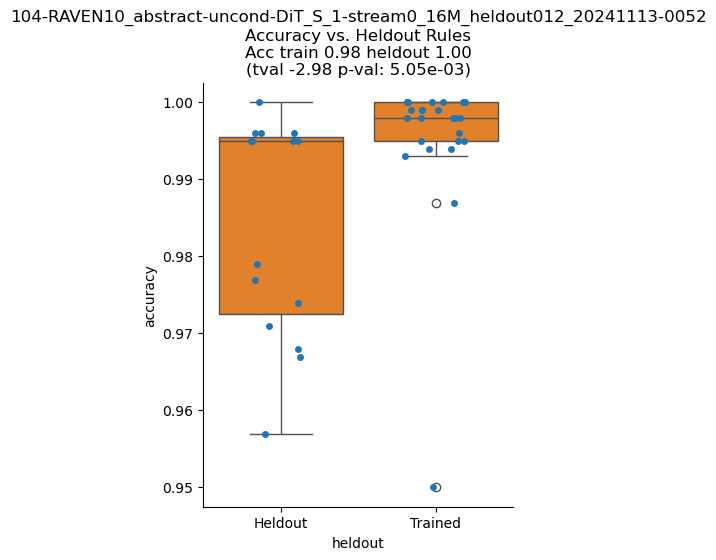

105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11       0.996575             1.0  25.0  1000000  avgtoken


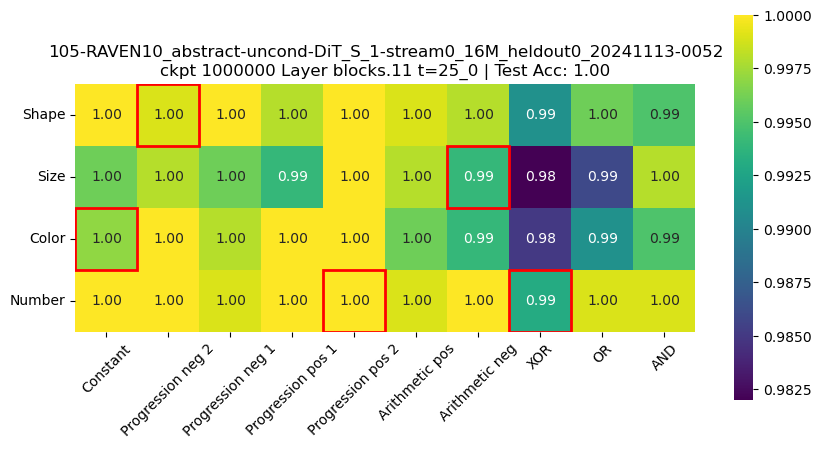

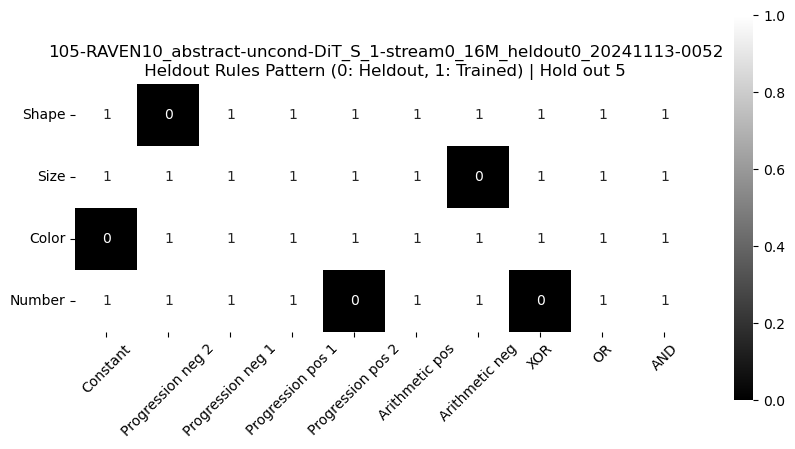

105-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0_20241113-0052 t-stat: 0.01, p-val: 9.89e-01


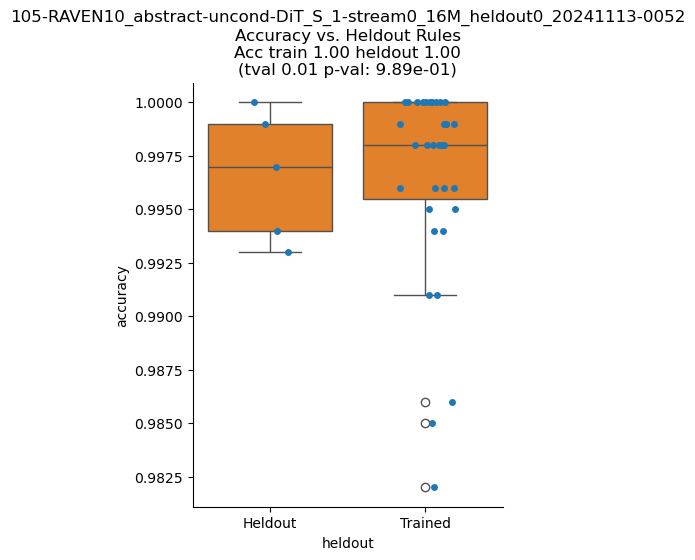

106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9864        0.999975  25.0  1000000  avgtoken


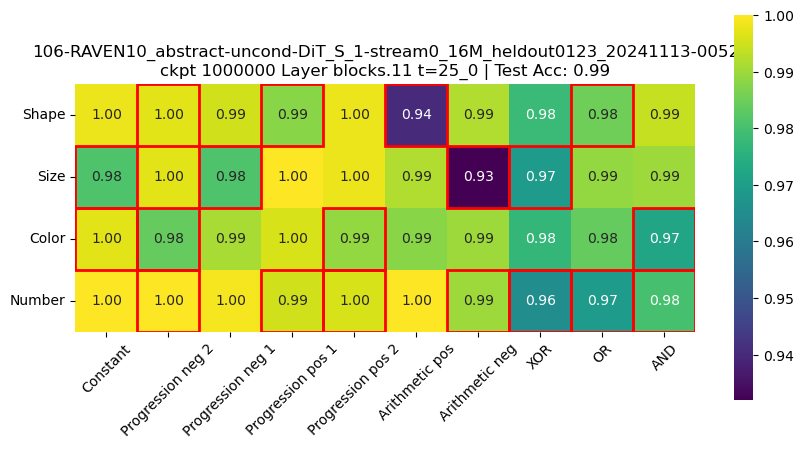

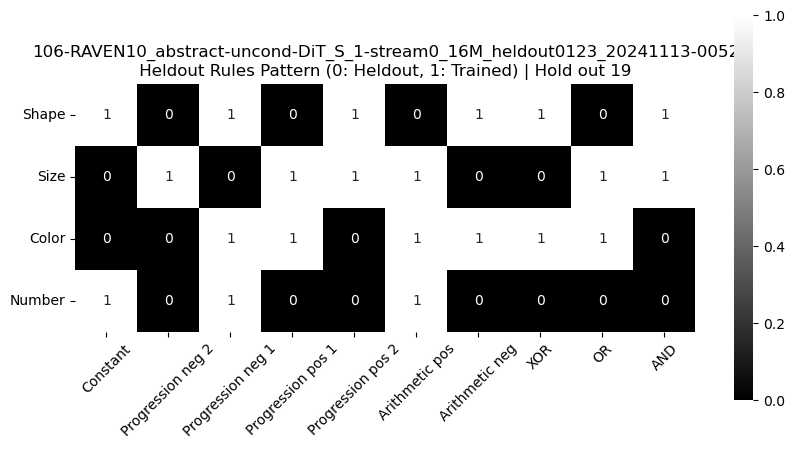

106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout0123_20241113-0052 t-stat: -3.05, p-val: 4.15e-03


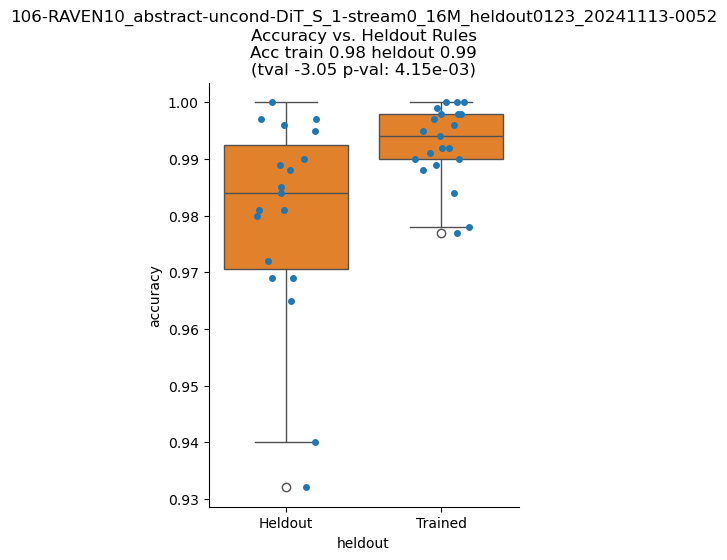

106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9757        0.995492  25.0  1000000  avgtoken


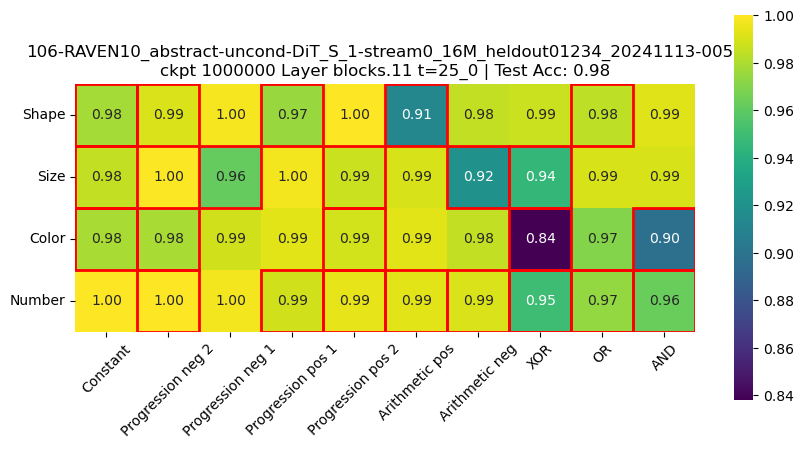

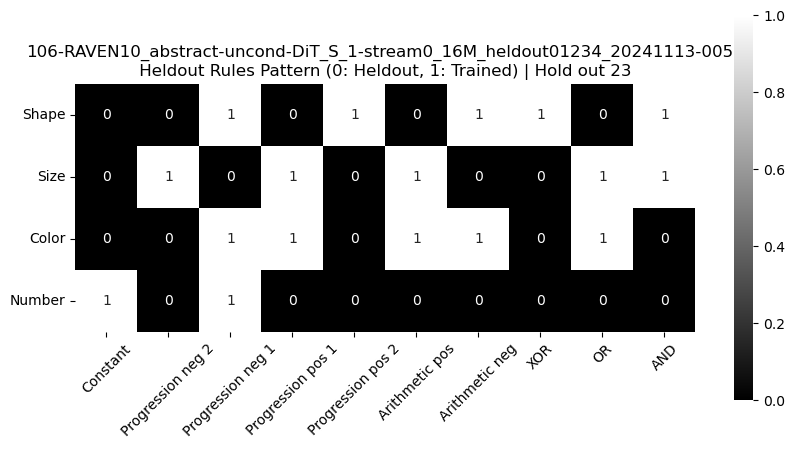

106-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout01234_20241113-0052 t-stat: -2.84, p-val: 7.20e-03


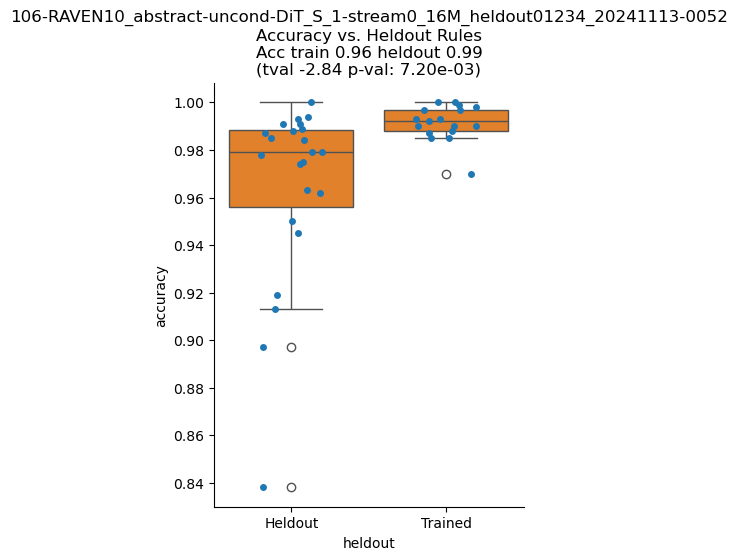

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11        0.97785        0.987575  25.0  1000000  avgtoken


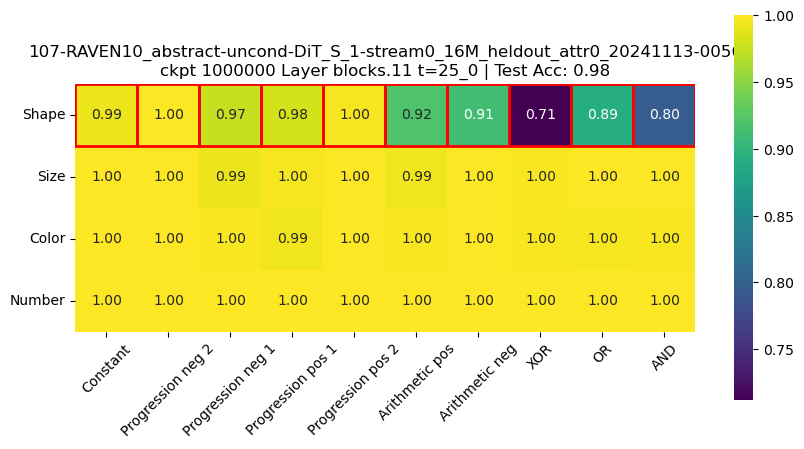

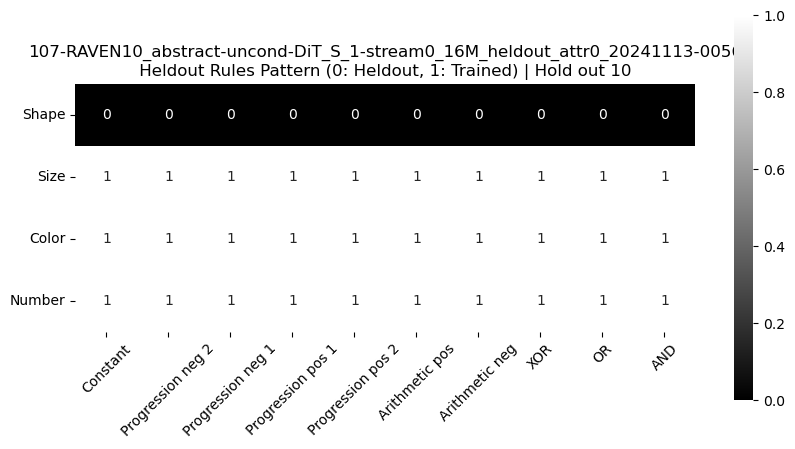

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr0_20241113-0056 t-stat: -4.75, p-val: 2.93e-05


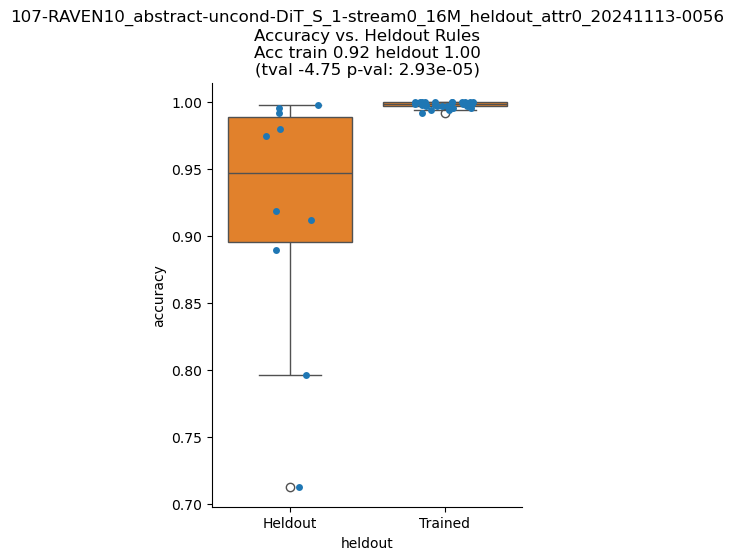

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11        0.99065        0.999483  25.0  1000000  avgtoken


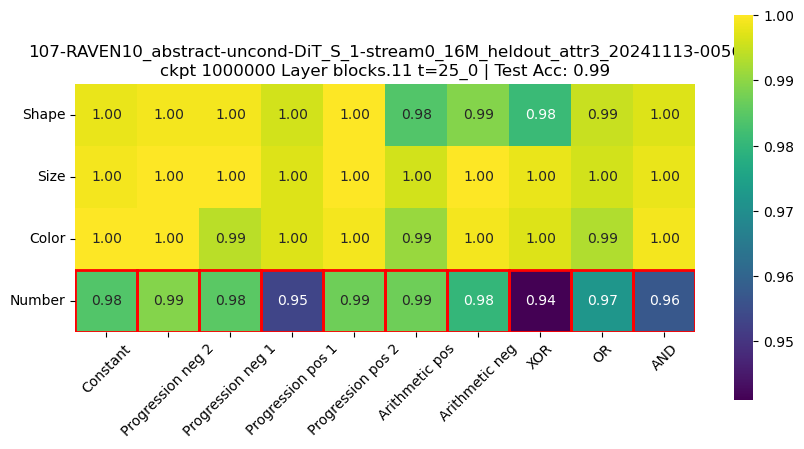

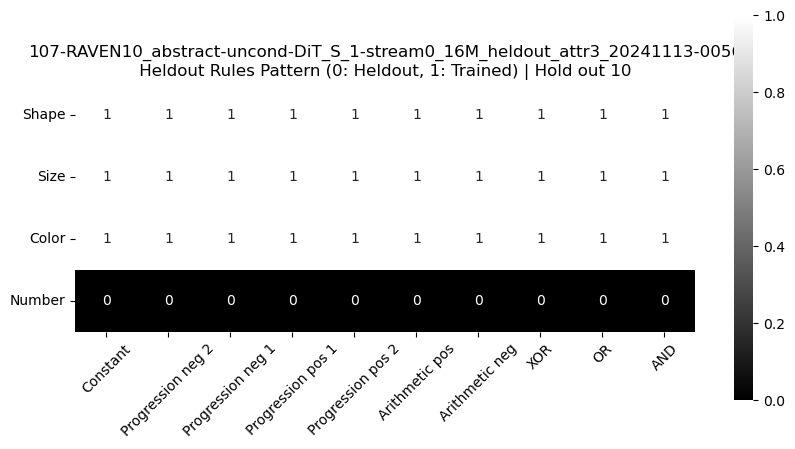

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_attr3_20241113-0056 t-stat: -6.75, p-val: 5.45e-08


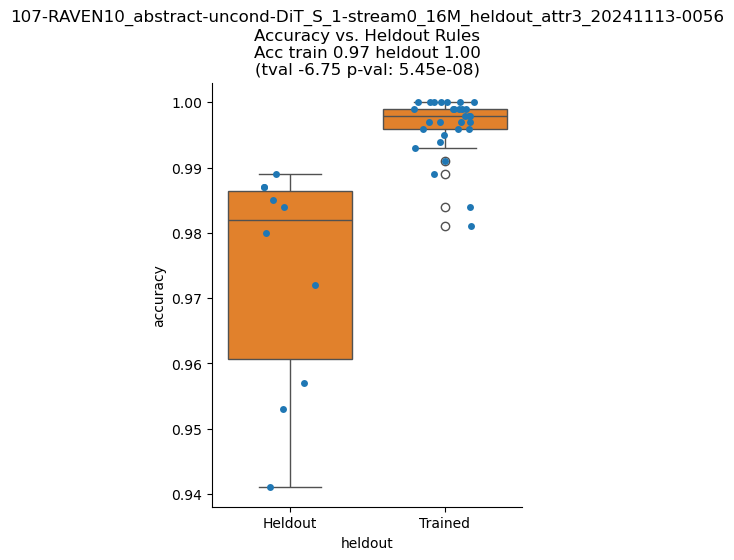

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11        0.99635             1.0  25.0  1000000  avgtoken


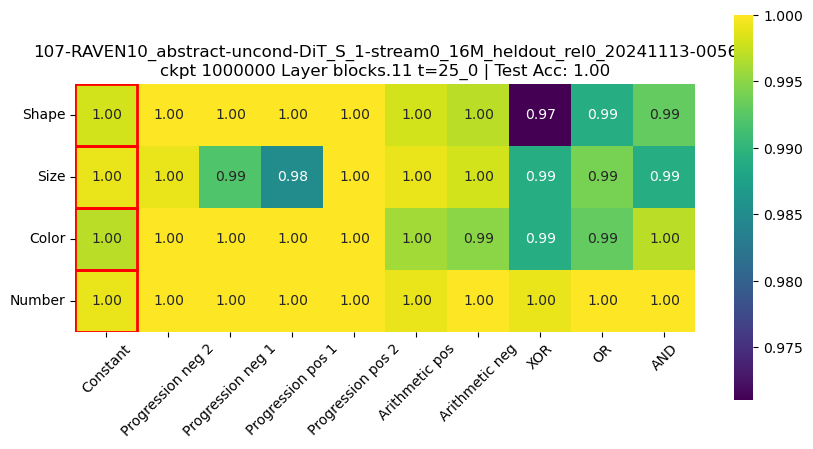

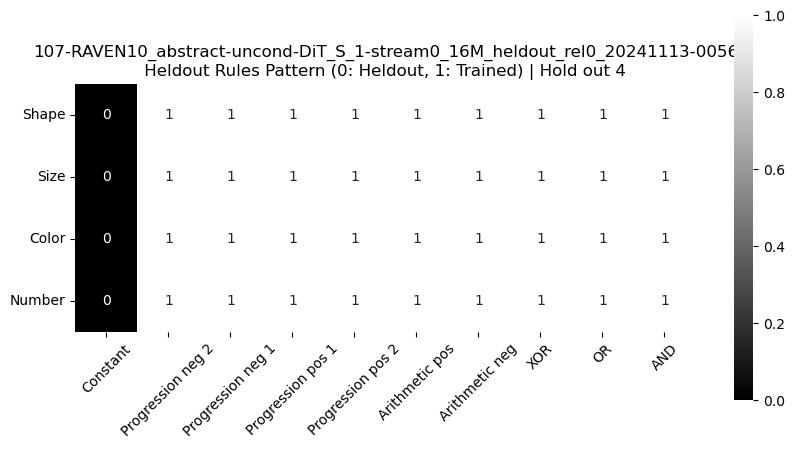

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel0_20241113-0056 t-stat: 0.69, p-val: 4.95e-01


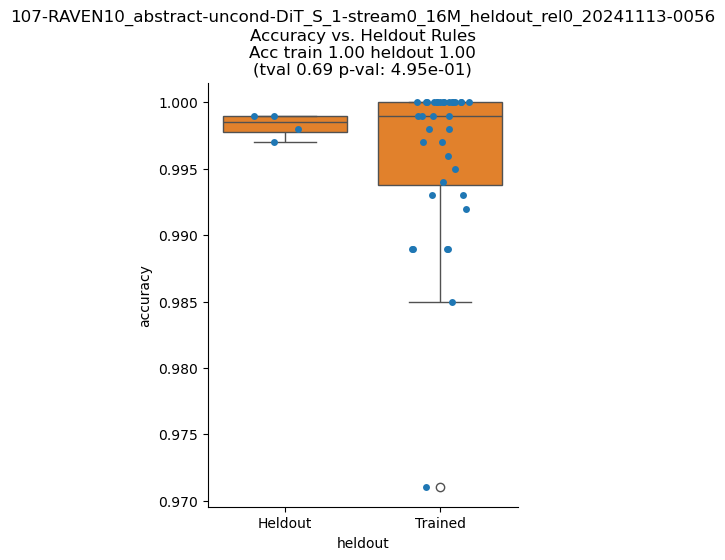

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel3_20241113-0056          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9976             1.0  25.0  1000000  avgtoken


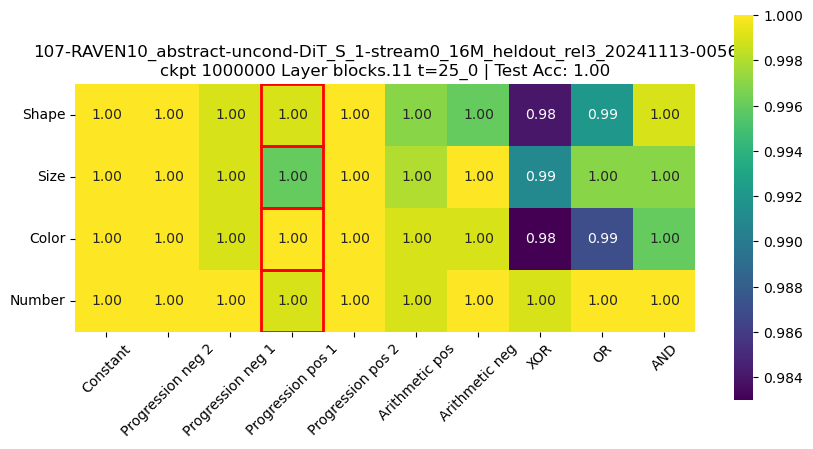

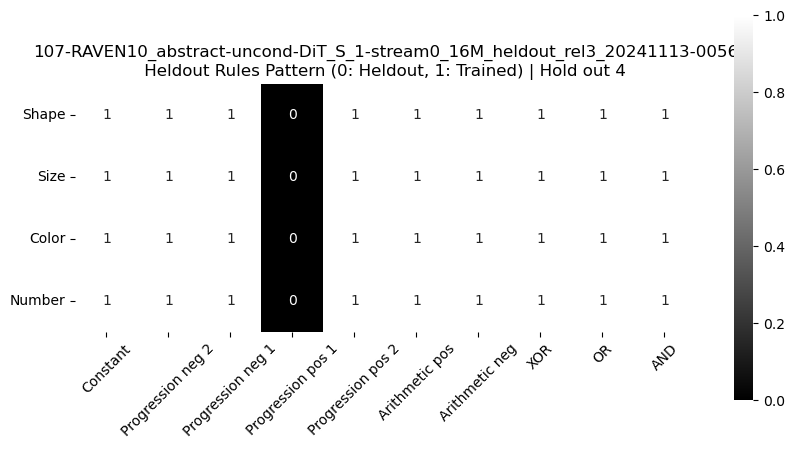

107-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel3_20241113-0056 t-stat: 0.44, p-val: 6.64e-01


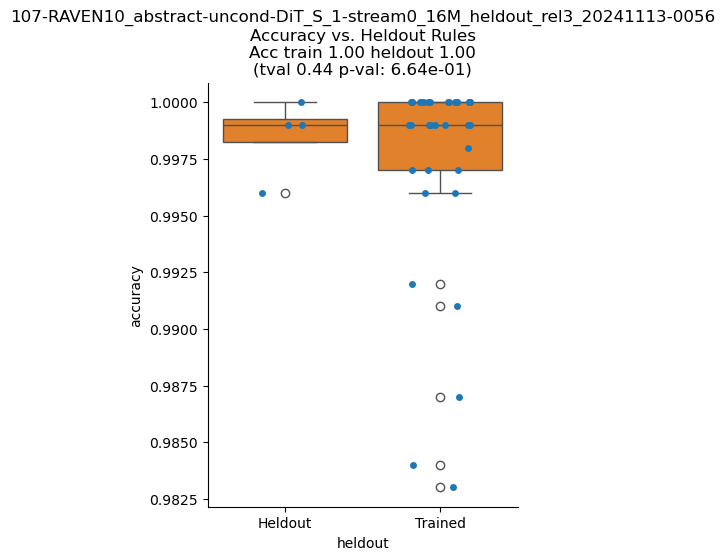

108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel5_20241113-0057          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11       0.995525        0.999992  25.0  1000000  avgtoken


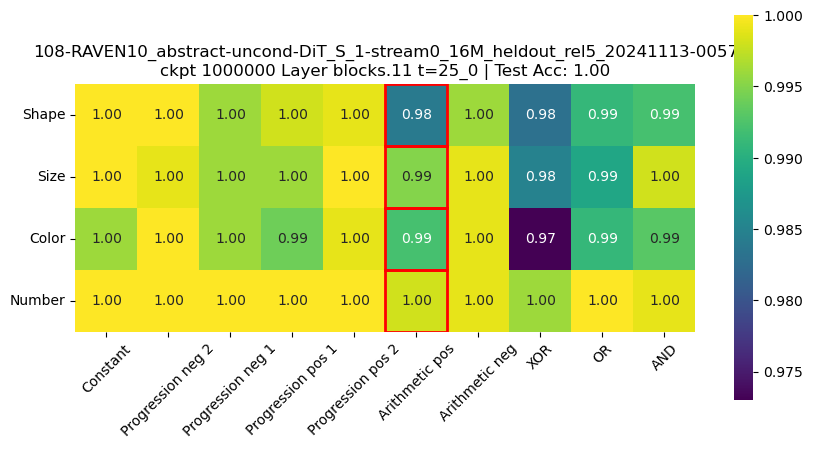

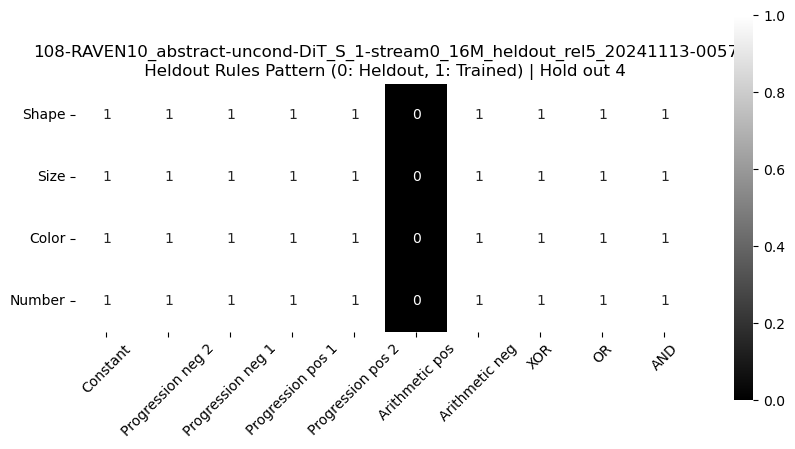

108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel5_20241113-0057 t-stat: -1.18, p-val: 2.46e-01


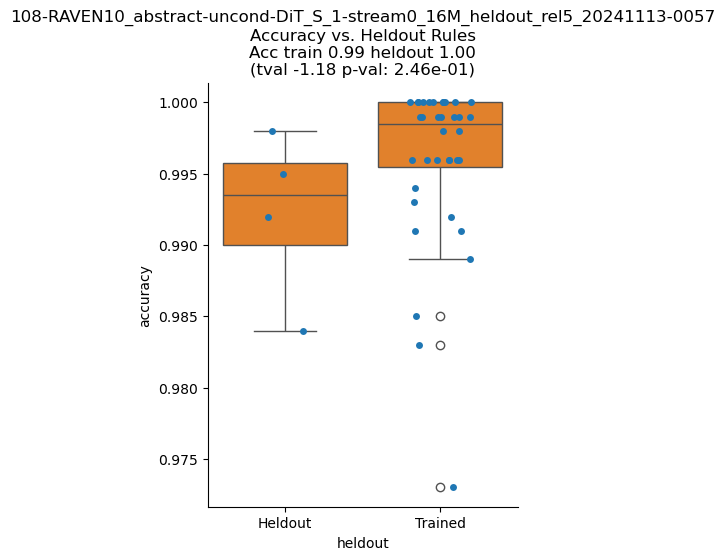

108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057          Layer  Test Accuracy  Train Accuracy     t    epoch    dimred
209  blocks.11         0.9941        0.999317  25.0  1000000  avgtoken


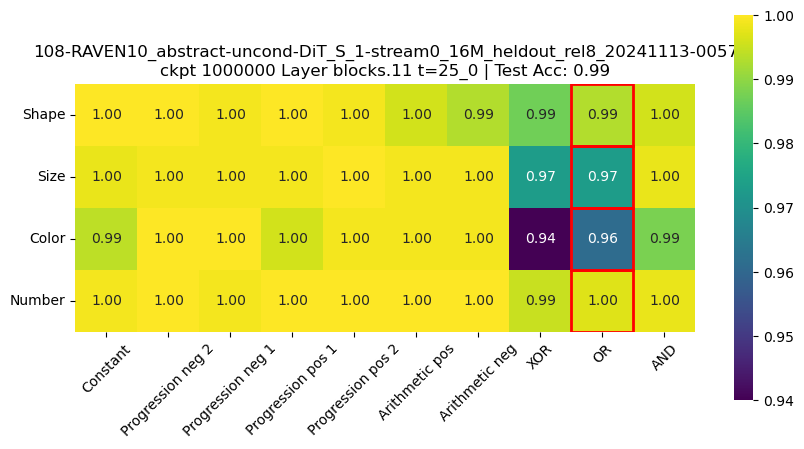

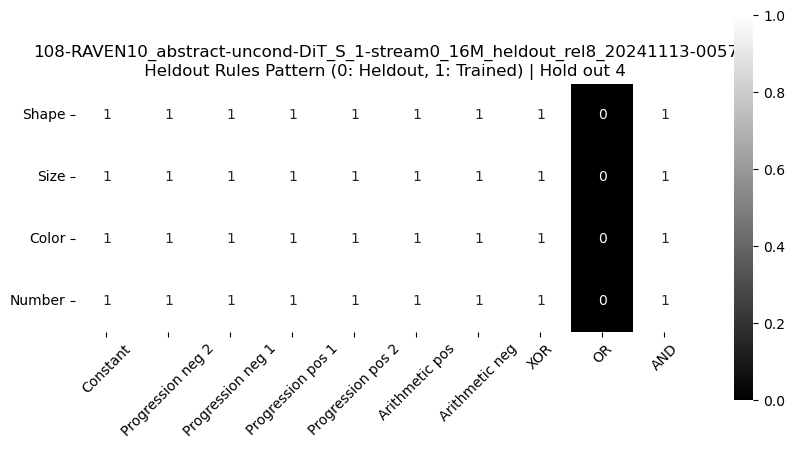

108-RAVEN10_abstract-uncond-DiT_S_1-stream0_16M_heldout_rel8_20241113-0057 t-stat: -2.41, p-val: 2.07e-02


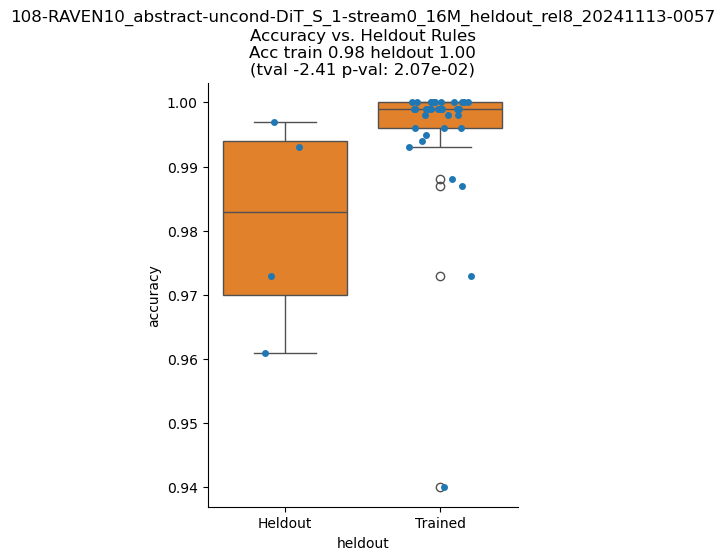

In [66]:
from scipy import stats
syndir = join(figroot, "synopsis")
for expname in expnames:
    expdir = join(exproot, expname)
    figexpdir = join(figroot, expname)
    os.makedirs(figexpdir, exist_ok=True)
    args_path = join(expdir, "args.json")
    assert os.path.exists(args_path), f"Args file not found for {expname}"
    heldout_ids = json.load(open(args_path, "r"))["heldout_ids"]
    repr_dir = join(expdir, "repr_classifier")
    syn_df = pd.read_csv(join(repr_dir, "repr_classifier_synopsis.csv"))
    syn_df_query = syn_df.query("epoch == 1000000 and dimred == 'avgtoken' and t == 25.0 and Layer == 'blocks.11'")
    best_row = syn_df_query.nlargest(1, "Test Accuracy")
    print(expname, best_row)
    test_acc = best_row["Test Accuracy"].item()
    t_str = str(best_row["t"].item()).replace(".", "_")
    dimred_str = best_row["dimred"].item()
    epoch_str = f"{best_row['epoch'].item():07d}"
    layer_str = best_row["Layer"].item()
    # load the results_col for the corresponding setting 
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_{dimred_str}_ckpt{epoch_str}.pkl"), "rb"))
    result_dict_layer = results_col[layer_str]
    pred_cls = result_dict_layer['pred_cls'].cpu()
    cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
    acc_per_rule = np.diag(cm) / cm.sum(axis=1)
    ax1 = plot_rule_heatmap(acc_per_rule.reshape(4,10), heldout_rules=heldout_ids, title=f"{expname}\nckpt {epoch_str} Layer {layer_str} t={t_str} | Test Acc: {test_acc:.2f}")
    saveallforms(figexpdir, f"acc_per_rule_{layer_str}_t{t_str}_ckpt{epoch_str}", )
    saveallforms(syndir, f"acc_per_rule_{expname}_{layer_str}_t{t_str}_ckpt{epoch_str}", )
    plt.show()
    # plot the heldout rules pattern
    rule_vec = np.ones(40) # 40 rules in total
    rule_vec[heldout_ids] = 0 # set the heldout rules to 0
    ax2 = plot_rule_heatmap(rule_vec.reshape(4,10), heldout_rules=[], title=f"{expname}\n Heldout Rules Pattern (0: Heldout, 1: Trained) | Hold out {len(set(heldout_ids))} ", fmt=".0f", cmap="gray")
    saveallforms(figexpdir, f"heldout_rules_pattern", )
    saveallforms(syndir, f"heldout_rules_pattern_{expname}", )
    plt.show()
    
    # plot the scatter plot of accuracy vs. heldout rules, trained vs heldout
    df = pd.DataFrame({"accuracy": acc_per_rule, "heldout": rule_vec})
    fig, ax = plt.subplots(1,1,figsize=(4, 5.5))
    sns.stripplot(x="heldout", y="accuracy", data=df, ax=ax, jitter=0.2, dodge=True)
    sns.boxplot(x="heldout", y="accuracy", data=df, ax=ax)
    # perform t test
    t_stat, p_val = stats.ttest_ind(df[df["heldout"] == 0]["accuracy"], df[df["heldout"] == 1]["accuracy"])
    print(f"{expname} t-stat: {t_stat:.2f}, p-val: {p_val:.2e}")
    # set ticks 0, 1
    test_acc_train = df[df['heldout'] == 0]['accuracy'].mean()
    test_acc_heldout = df[df['heldout'] == 1]['accuracy'].mean()
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Heldout", "Trained"])
    ax.set_title(f"{expname}\nAccuracy vs. Heldout Rules\nAcc train {test_acc_train:.2f} heldout {test_acc_heldout:.2f}\n(tval {t_stat:.2f} p-val: {p_val:.2e})")
    saveallforms(figexpdir, f"train_vs_heldout_cmp_{layer_str}_t{t_str}_ckpt{epoch_str}", )
    saveallforms(syndir, f"train_vs_heldout_cmp_{expname}_{layer_str}_t{t_str}_ckpt{epoch_str}", )
    plt.show()
    # break 
#     heldout_profiles[expname] = heldout_ids
# for expname, heldout_ids in heldout_profiles.items():
#     print(expname, '\t heldout #', len(set(heldout_ids)), set(heldout_ids))

In [31]:
acc_per_rule

array([0.912, 0.978, 0.962, 0.841, 0.97 , 0.764, 0.925, 0.588, 0.744,
       0.779, 0.901, 0.969, 0.891, 0.938, 0.926, 0.906, 0.806, 0.634,
       0.88 , 0.704, 0.882, 0.872, 0.936, 0.927, 0.916, 0.907, 0.767,
       0.657, 0.866, 0.711, 0.99 , 0.985, 0.999, 0.982, 0.979, 0.987,
       0.983, 0.934, 0.966, 0.948])

In [25]:
result_dict_layer.pred_cls.shape

torch.Size([40000])

### Scratch

In [ ]:
from rule_new_utils import attribute_dict, relation_dict
from sklearn.metrics import confusion_matrix
def visualize_cm(cm, heldout_rules, titlestr=""):
    figh1 = plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(4, 10) / 1000 * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    add_rectangles(heldout_rules)
    plt.xticks(np.arange(10)+0.5, [relation_dict[i] for i in range(10)], rotation=45)
    plt.yticks(np.arange(4)+0.5, [attribute_dict[i] for i in range(4)], rotation=0)
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh2, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        if int(label.get_text()) in heldout_rules:
            label.set_color('red')
    plt.show()
    return figh1, figh2
    
    
def visualize_cm_default(cm, heldout_rules, titlestr=""):
    plt.figure(figsize=(10, 4))
    sns.heatmap(np.diag(cm).reshape(1,-1) / cm.sum(axis=1)[None,] * 100, cmap="Blues", annot=True, fmt=".1f", cbar=False)
    # for rule_id in heldout_rules:
    #     row = rule_id // 10
    #     col = rule_id % 10
    #     plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
    plt.title(f"Accuracy Percentage (Diagonal confusion matrix)\n{titlestr}")
    plt.show()

    figh, ax = plt.subplots(1,1,figsize=(12, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix {titlestr}")
    plt.ylabel('True Rule')
    plt.xlabel('Predicted Rule')
    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     if int(label.get_text()) in heldout_rules:
    #         label.set_color('red')
    plt.show()

* Show the pattern of held out rules
* Show the pattern of accuracy split by rules

In [ ]:

for t_scalar in [25.0]: #[1.0, 10.0, 25.0, 50.0, 100.0, 250.0, 500.0, 1000.0]:
    t_str = str(t_scalar).replace(".", "_")
    results_col = pkl.load(open(join(repr_dir, f"results_col_t{t_str}_avgtoken_ckpt1000000EMA.pkl"), "rb"))
    for layer in results_col.keys():
        pred_cls = results_col[layer]['pred_cls'].cpu()
        cm = confusion_matrix(y_true=y_test, y_pred=pred_cls, )
        fig1, fig2 = visualize_cm(cm, heldout_rules=heldout_rules, titlestr=f"{expname}\nckpt 1000000EMA Layer {layer} t={t_scalar}")